# MITGCM Vorticity Gradients Climatology

**Purpose**: Code for computing the velocity gradient climatology map. The goal here is to gain insight into the reason for the structure of the decorrelation time scale. Our hypothesis is that there is a standing feature off the coast which will have signal in the vorticity, divergence or strain fields. 

**Luke Colosi | lcolosi@ucsd.edu**

Force matplotlib plots to display directly within the output cell of the notebook

In [1]:
%matplotlib inline

Import python libraries

In [2]:
import sys
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt 
from netCDF4 import Dataset, num2date
from datetime import datetime
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os
import cmocean

# Set path to access python functions
ROOT = '/Users/lukecolosi/Desktop/projects/graduate_research/Gille_lab/'
sys.path.append(ROOT + 'AirSeaCoupling/tools/')

#--- Other Functions ---# 
import cartopy_figs as cart
from autocorr import compute_autocorr, compute_decor_scale
from spectra import spectrum1D_frequency
from lsf import unweighted_lsf, compute_amp_phase, compute_amp_phase_unc, detrend
from structure_functions import compute_structure_function

Set data analysis parameters

In [3]:
# Set processing parameters
option_plot          = 0      # Specifies if supplementary plots are plotted
option_var           = 'strain' # Specifies which data to plot a climatology of. Options include: 'curl', 'div', 'strain', 'speed', 'dir'

# Set time and space parameters  
lat_bnds     = [33, 35]                      # Specifies the latitude bounds for the region to analyze
lon_bnds     = [-123 % 360, -120 % 360]      # Specifies the longitude bounds for the region to analyze

# Set path to project directory
PATH = ROOT + 'AirSeaCoupling/data/mitgcm/SWOT_MARA_RUN4_LY/'
PATH_figs =  ROOT + 'AirSeaCoupling/figs_server/mitgcm/scale_analysis/'
PATH_bathy  = ROOT + 'AirSeaCoupling/data/bathymetry/'

# Set plotting parameters 
fontsize = 16

Load mitgcm data netcdf files 

In [4]:
#--- MITgcm velocity gradient Data ---# 
filename = PATH + "mitgcm_intermediate_data_gradients_depth_0.5.nc"
nc = Dataset(filename, 'r')

# Extract data variables
lon = nc.variables['lon'][:]
lat = nc.variables['lat'][:]
time =  num2date(nc.variables['time_dt'][:], nc.variables['time_dt'].units)

if option_var == 'curl':
    data = nc.variables['CURL'][:]
elif option_var == 'div':
    data = nc.variables['DIV'][:]
elif option_var == 'strain':
    data = nc.variables['STRAIN'][:]
elif option_var == 'speed': 
    data = nc.variables['SPEED'][:]
elif option_var == 'dir': 
    data = nc.variables['DIR'][:]

# Convert cftime.DatetimeGregorian to Python datetime objects
time_dt = np.array([datetime(d.year, d.month, d.day, d.hour, d.minute, d.second) for d in time])

Read in bathymetry data

In [5]:
# Load bathymetry data 
filename = PATH_bathy + "topo_25.1.nc"
ds_bathy = xr.open_dataset(filename, engine="netcdf4")

# Extract data variables
lon_b = ds_bathy["lon"]  # Longitude
lat_b = ds_bathy["lat"]  # Latitude
bathy = ds_bathy["z"]    # Elevation/Bathymetry

# Convert convesion of longitude (neg from the prime meridian to positive definite wrapping around the earth)
lon_n = lon_b % 360

# Set max and min values 
lon_min = lon_bnds[0]
lon_max = lon_bnds[1]
lat_min = lat_bnds[0]
lat_max = lat_bnds[1]

# Extract data from bathymetry 
lon_grid = lon_n[(lon_n >= lon_min) & (lon_n <= lon_max)]
lat_grid = lat_b[(lat_b >= lat_min) & (lat_b <= lat_max)]
bathy_grid   = bathy[(lat_b >= lat_min) & (lat_b <= lat_max),(lon_n >= lon_min) & (lon_n <= lon_max)]

Compute climatology of the velocity gradient field 

In [6]:
# Initialize arrays 
data_clima_m    = []
data_clima_std  = []
data_clima_stdm = []
time_month           = []

# Set the month time array
months = np.array([m.month for m in time])

# Loop through months
for m in range(1, 13):

    # Find the indicies for the ith month
    ind = months == m

    # Slice data and time for ith month
    tmp      = data[ind]
    tmp_time = time[ind] 

    # Compute the monthly mean and standard deviation
    data_clima_m.append(np.mean(tmp, axis=0))
    data_clima_std.append(np.std(tmp, axis=0, ddof=1))

    # Compute the standard error of the mean (assuming that each data point is an independent observations)
    data_clima_stdm.append(np.std(tmp, axis=0, ddof=1)/np.sqrt(np.count_nonzero(~np.isnan(tmp), axis=0)))

    # Save the month time variable 
    time_month.append(m)

# Convert lists to an array
data_clima_m = np.array(data_clima_m)
data_clima_std = np.array(data_clima_std)
data_clima_stdm = np.array(data_clima_stdm)
time_month = np.array(time_month)

Plot the climatology of velocity gradients

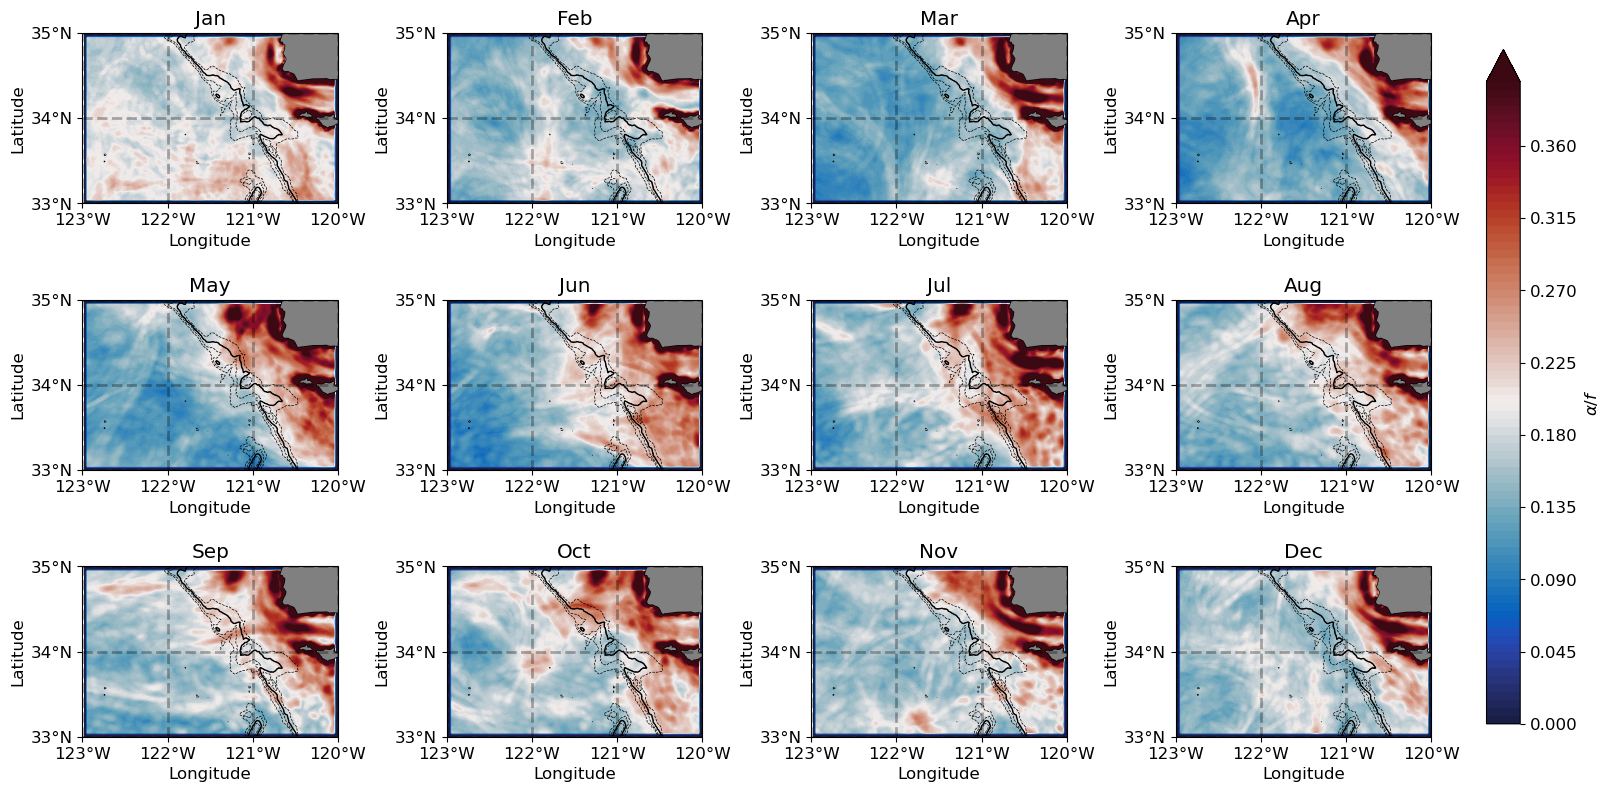

In [7]:
# Set plotting parameters
projection = ccrs.PlateCarree(central_longitude=0.0)
xticks = [-123, -122, -121, -120]
yticks = [ 33.00, 34.00, 35.00]
resolution = "10m"
fontsize = 12

if option_var == 'curl': 
    levels = np.arange(-0.2,0.2+0.005,0.005)
    label = r'$\zeta/f$'
    cmap = cmocean.cm.curl
    extend = 'both'
elif option_var == 'div': 
    levels = np.arange(-0.05,0.05 + 0.0005,0.0005)
    label = r' $\delta/f$'
    cmap = cmocean.cm.balance
    extend = 'both'
elif option_var == 'strain': 
    levels = np.arange(0,0.4 + 0.005,0.005)
    label = r'$\alpha/f$'
    cmap = cmocean.cm.balance
    extend = 'max'
elif option_var == 'speed': 
    levels = np.arange(0,0.4 + 0.005,0.005)
    label = r'$|\bf{u}|$ (ms$^{-1}$)'
    cmap = cmocean.cm.speed_r
    extend = 'max'
elif option_var == 'dir': 
    levels = np.arange(0,360 + 20,20)
    label = r'$\theta$ (degrees)'
    cmap = cmocean.cm.phase
    extend = 'neither'

# Set the fontsize
plt.rcParams.update({'font.size': fontsize})

# Create 3x4 subplot grid
fig, axes = plt.subplots(3, 4, figsize=(16, 8), constrained_layout=True, subplot_kw={"projection": projection})
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Loop over months
for i in range(12):

    # Set the row and column iteration
    row = i // 4
    col = i % 4

    # Set the axis for the ith plot
    ax = axes[row, col]

    # Set figure axes 
    cart.set_subplots(ax, projection, resolution, lon_min=-123, lon_max=-120, lat_min=33, lat_max=35) 

    # Plot velocity gradient for the ith month
    pcm = ax.contourf(lon, lat, data_clima_m[i], levels=levels, cmap=cmap,extend=extend)
    ax.set_title(month_names[i])
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    # Plot depth contour lines
    levels_bath = np.arange(-3000,-1000,500)
    contour1 = ax.contour(lon_grid, lat_grid, bathy_grid,levels=levels_bath, colors='black', linewidths=0.5, linestyles='dashed')
    contour2 = ax.contour(lon_grid, lat_grid, bathy_grid,levels=[-2000], colors='black', linewidths=1, linestyles='solid')

    # Set grid ticks 
    cart.set_grid_ticks(
        ax,
        projection=ccrs.PlateCarree(),
        xticks=xticks,
        yticks=yticks,
        xlabels=True,
        ylabels=True,
        grid=True,
        fontsize=fontsize,
        color="black",
    )

# Add colorbar
cbar = fig.colorbar(pcm, ax=axes, orientation='vertical', fraction=0.025, pad=0.02)
cbar.set_label(label)

plt.show()